In [35]:
import torch.nn.utils.prune as prune
import torch
import torchvision.transforms
from torchvision import datasets, transforms
from torch import nn
from typing import Optional, List, Tuple, Union

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import math
import warnings

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules.module import Module
from torch.nn.modules.utils import _single, _pair, _triple, _reverse_repeat_tuple
from torch._torch_docs import reproducibility_notes

from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from typing import Optional, List, Tuple, Union

import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

# own module
from visualisation.feature_map import *

import random


mode = "l1"

['../helper', './helper', '/helper', 'helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\examples', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


In [36]:
class _ConvNd(torch.nn.Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
        ...

    in_channels: int
    _reversed_padding_repeated_twice: List[int]
    out_channels: int
    kernel_size: Tuple[int, ...]
    stride: Tuple[int, ...]
    padding: Union[str, Tuple[int, ...]]
    dilation: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: Tensor
    bias: Optional[Tensor]

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, ...],
                 stride: Tuple[int, ...],
                 padding: Tuple[int, ...],
                 dilation: Tuple[int, ...],
                 transposed: bool,
                 output_padding: Tuple[int, ...],
                 groups: int,
                 bias: bool,
                 padding_mode: str,
                 device=None,
                 dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        print(factory_kwargs)
        super().__init__()
        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")

        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        # `_reversed_padding_repeated_twice` is the padding to be passed to
        # `F.pad` if needed (e.g., for non-zero padding types that are
        # implemented as two ops: padding + conv). `F.pad` accepts paddings in
        # reverse order than the dimension.
        if isinstance(self.padding, str):
            self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
            if padding == 'same':
                for d, k, i in zip(dilation, kernel_size,
                                   range(len(kernel_size) - 1, -1, -1)):
                    total_padding = d * (k - 1)
                    left_pad = total_padding // 2
                    self._reversed_padding_repeated_twice[2 * i] = left_pad
                    self._reversed_padding_repeated_twice[2 * i + 1] = (
                        total_padding - left_pad)
        else:
            self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

        if transposed:
            self.weight = Parameter(torch.empty(
                (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
            self.importance = Parameter(torch.empty(
                (in_channels, out_channels // groups), **factory_kwargs))
            
        else:
            self.weight = Parameter(torch.empty(
                (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
            self.importance = Parameter(torch.empty(
                (out_channels, in_channels // groups), **factory_kwargs))
            
        if bias:
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()


class CustomConv2d(_ConvNd):
    
    # additionally needed
    """
    
    position
    activated channels
    connection between channels
    
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)
        
        # this layer id
        layer_id = 0
        
        # within this layer, a whole filter can be deactivated
        # within a filter, single channels can be deactivated
        # within this layer, filters can be swapped

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super().__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        
        # this is written in c++ - try not to change ...
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)



In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = CustomConv2d(1, 32, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv2 = CustomConv2d(32, 64, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv3 = CustomConv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv1x1 = CustomConv2d(128, 10, kernel_size=1, stride=1, padding=0, dilation=1)
        
        self.K = 100 
        self.L = 10 # last one
        self.num_of_bases = 1 # 3rd dim
        
        if False:
            self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv3 = Conv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv1x1 = Conv2d(128, 10, kernel_size=1, stride=1, padding=0, dilation=1)
        #self.dropout1 = nn.Dropout(0.25)
        #self.dropout2 = nn.Dropout(0.5)
        # 4x16384
        # self.fc1 = nn.Linear(10*10*10, 10)
        #self.fc2 = nn.Linear(10, 10)
        
        #self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(10, 10)
        
        self.mish1 = torch.nn.Mish()
        self.mish2 = torch.nn.Mish()
        self.mish3 = torch.nn.Mish()
        self.mish1x1 = torch.nn.Mish()
        
        #self.sub_concept_pooling = nn.modules.MaxPool2d((self.K, 1), stride=(1,1))
        #self.instance_pooling = nn.modules.MaxPool2d((opt.num_of_bases, 1), stride=(1,1))
        
        self.flat = nn.Flatten()
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.mish1(x)
        
        x = self.conv2(x)
        x = self.mish2(x)
        
        x = self.conv3(x)
        x = self.mish3(x)
        
        x = self.conv1x1(x)
        x = self.mish1x1(x)
        
        # print(x.shape)
        
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        
        #print(x.size())
        #print(x.size()[2:])
        
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        
        x = x.reshape(x.size(0), -1)
        x = self.fc3(x)
        
        # x = self.flat(x)
        
        #x = self.fc2(x)
        
        
        #x = x.view(-1, self.L, self.K, 10)
        
        # input, kernel_size, stride, padding, dilation, ceil_mode
        #x = self.sub_concept_pooling(x).view(-1, self.L, self.num_of_bases).permute(0,2,1).unsqueeze(1)
        
        # output = F.sigmoid(x)
        # x = x.reshape(x.size(0), -1)
        
        #x = torch.flatten(x, 1)
        # x = self.fc1(x)
        #x = F.relu(x)
        
        #x = self.dropout2(x)
        #x = self.fc2(x)
        #output = F.log_softmax(x, dim=1)
        
        x = self.sigmoid(x)
        
        return x





In [51]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        
        
        data, target = data.to(device), target.unsqueeze(1) # .to(device)
        optimizer.zero_grad()
        output = model(data)
        
        target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
        
        if batch_idx == -1:
            print(data.shape) # torch.Size([4, 1, 28, 28])
            print(target)
            """
            tensor([[8],
            [7],
            [2],
            [7]])
            """
            print(target_multi_hot)
            """
            tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
            [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
            """
        
        loss = F.binary_cross_entropy(output, target_multi_hot)
        loss.backward()
        optimizer.step()
        if batch_idx % (args.log_interval*1000) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            


def test(args, model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.unsqueeze(1) # .to(device)
            
            output = model(data)
            
            target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
            test_loss += F.binary_cross_entropy(output, target_multi_hot, reduction='mean').item()
        
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.to(device).view_as(pred)).sum().item()
            
            """
            if i == 0 and epoch % args.log_interval == 0:
            # if False: # i == 0:
                print(data.shape)
                layer = model.conv1x1 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv
                # run feature map
                dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
                dd.run(data)
                dd.plot(path=f"example_results/feature_map_{epoch}.png")
                """

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

class Parser():
    def __init__(self):
        self.batch_size = 128
        self.test_batch_size = 1
        self.epochs = 100
        self.lr = 0.1
        self.gamma = 0.7
        self.log_interval = 5
        self.save_model = True
        

def main_train():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('example_data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('example_data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    #scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader, epoch)
        #scheduler.step()
        
        
        if args.save_model and epoch % args.log_interval == 0:
            torch.save(model.state_dict(), f"example_results/mnist_cnn_{epoch}.ckpt")


def main_test():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        test_kwargs.update(cuda_kwargs)

    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset2 = datasets.MNIST('example_data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    if True:
        model.load_state_dict(torch.load("example_results/mnist_cnn_5.ckpt"))
    else:
        model.load_state_dict(torch.load("example_results/pruned_model.ckpt"))
    

    # model = torch.load(model.state_dict(), "example_results/mnist_cnn_30.ckpt")
    test(args, model, device, test_loader, 0)
    
    return model
        
    
            


In [52]:
model_to_prune = main_test()

{'device': None, 'dtype': None}
{'device': None, 'dtype': None}
{'device': None, 'dtype': None}
{'device': None, 'dtype': None}

Test set: Average loss: 0.2134, Accuracy: 5488/10000 (55%)



In [60]:
if mode == "l1":
    prune.l1_unstructured(model_to_prune.conv2, name="weight", amount=0.7)

In [61]:
if mode == "random":
    prune.random_unstructured(model_to_prune.conv2, name="weight", amount=0.7)

In [62]:
print(model_to_prune.conv2._forward_pre_hooks)

OrderedDict([(2, <torch.nn.utils.prune.L1Unstructured object at 0x0000018586A03820>)])


In [63]:
prune.remove(model_to_prune.conv2, "weight")

CustomConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(3, 3))

In [64]:
torch.save(model_to_prune.state_dict(), f"example_results/pruned_model.ckpt")

In [65]:
print(model_to_prune.conv2.weight)

Parameter containing:
tensor([[[[ 0.0587,  0.0000,  0.0640],
          [ 0.0000,  0.0000, -0.0502],
          [-0.0000, -0.0550,  0.0000]],

         [[-0.0000,  0.0487, -0.0000],
          [ 0.0626, -0.0000,  0.0448],
          [ 0.0000, -0.0000,  0.0000]],

         [[ 0.0000, -0.0000,  0.0000],
          [-0.0000,  0.0469,  0.0000],
          [ 0.0000,  0.0675, -0.0000]],

         ...,

         [[ 0.0000,  0.0516,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0551,  0.0000, -0.0000]],

         [[ 0.0468, -0.0581, -0.0000],
          [ 0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0436]],

         [[ 0.0442,  0.0792,  0.0000],
          [ 0.0447, -0.0000,  0.0000],
          [ 0.0441, -0.0000,  0.0000]]],


        [[[ 0.0685,  0.0542,  0.0449],
          [-0.0000, -0.0457,  0.0537],
          [ 0.0000,  0.0000,  0.0488]],

         [[-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0544,  0.0000],
          [-0.0000,  0.0542,  0.0000]],

         

In [57]:
# Visualisation

In [58]:
model = model_to_prune

torch.Size([64, 32, 3, 3])


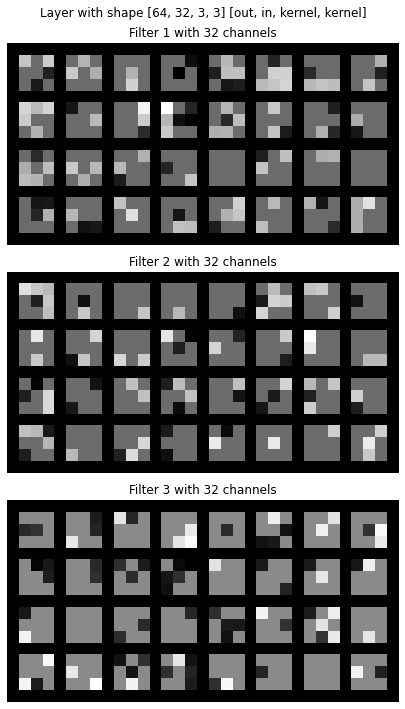

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visChannels(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    plt.figure(figsize=(nrow,rows) )
    plt.title(f"Channels with index {ch}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))


def visFilters(tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.title(f"Filter {filt}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))

def visFilters_subplot(subplot, tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # plt.figure( figsize=(nrow,rows) )
    subplot.set_title(f"Filter {filt+1} with {c} channels")
    subplot.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))
    subplot.axis('off')
    
layer = 1
filter = model.conv2.weight.data.clone()

print(model.conv2.weight.shape)

# need to match the network parameters!!!!
in_channels = 5
out_filters = 3 # 64


fig, subplot = plt.subplots(out_filters, figsize=(10, 10))
fig.suptitle(f'Layer with shape {list(model.conv2.weight.shape)} [out, in, kernel, kernel]')

for filt in range(0, out_filters):
    
    visFilters_subplot(subplot[filt], filter, filt=filt, allkernels=False)

    #plt.axis('off')
    #plt.ioff()
    
plt.tight_layout()
plt.savefig(f"example_results/filter_with_weights.png")
plt.show()
    
if False:    
    for filt in range(0, out_filters):

        visFilters(filter, filt=filt, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.tight_layout()
        #plt.savefig(f"examples/example_results/filter_with_weights.png")
        plt.show()

    for ch in range(0, in_channels):

        visChannels(filter, ch=ch, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()